# Foward Design Optimization - Interactive

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Implementation of a Conditional Variational Autoencoder (CVAE) including data preparation, training and evaluation.

**Dependencies**: 
- `DNN.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`
- `Saved Models\DNN_Model_Full_V2\DNN_Model_Full_V2.pth`

## Import

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import copy
import os
import pickle

from DataReader import DataReader
from Settings import Directory, Plotting_Parameters
from DNN import DNN
from Plot_Functions import plot_MV_interaction

import warnings
warnings.filterwarnings('ignore')

In [25]:
plot_params = Plotting_Parameters()
directory = Directory()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


## Load Data

In [88]:
datareader = DataReader()
df = datareader.load('Knee_Connection_Output_red.csv')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
extended_profiles_iter_3.csv
extenden_profiles_iter_1.csv
extenden_profiles_iter_2.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
Knee_Connection_Output_red.csv: (714385, 53)


## Load Forward Model

In [27]:
model_name = 'DNN_Model_Full_V2'
MODEL_FORWARD_SAVE_FILE = rf"Saved Models\{model_name}\{model_name}.pth"

model_forward = DNN()
model_forward = torch.load(MODEL_FORWARD_SAVE_FILE)

for key, value in model_forward.config.items():
    print(key, value)

features = model_forward.features

batch_size 256
epochs 3000
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Use larger network architecture and more features as training data. Also use Batch normalization


### Uncertainty to predicted error map

To quantify the uncertainty of new design, generate the errors and the uncertainty of the existing data, which can be used to link the uncertainty of a new profile, to a predicted error.

In [28]:
y_pred, test_loss = model_forward.evaluate()
y_true = model_forward.y_test.numpy()
error = np.abs((y_pred - y_true) / (y_true+1e-8)) * 100

In [29]:
mcd_mean, mcd_std_unbiased, mcd_preds = model_forward.mc_dropout_uncertainty(num_samples=200, dropout_prob=0.1)
uncertainty = mcd_std_unbiased / mcd_mean

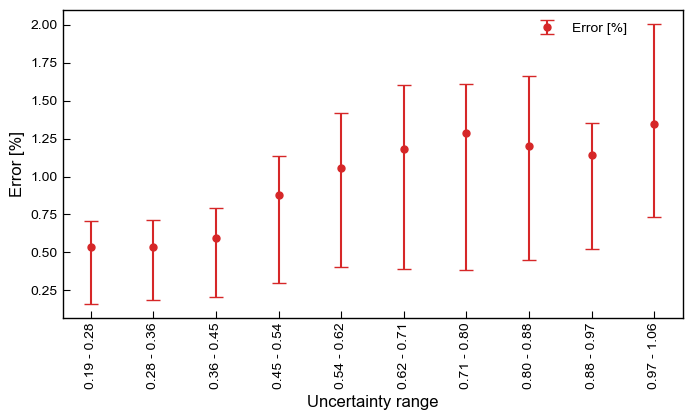

In [30]:
fig, ax = plt.subplots(figsize=(8,4))

counts, uncertainty_bins = np.histogram(uncertainty, bins=10)

error_mapping = []

for i in range(len(counts)):
    mask = np.logical_and(uncertainty >= uncertainty_bins[i], uncertainty < uncertainty_bins[i+1])

    error_bin = error[mask]

    error_bin_mean = error_bin.mean()

    confidence = 50
    error_lower_val = np.percentile(error_bin, (100 - confidence) / 2)
    error_upper_val = np.percentile(error_bin, confidence + (100 - confidence) / 2)

    error_lower_bound = error_bin_mean - error_lower_val
    error_upper_bound = error_upper_val - error_bin_mean

    error_bounds = np.array([[error_lower_bound], [error_upper_bound]])

    error_mapping.append([error_bin_mean, error_lower_bound, error_upper_bound])

    if i==0:
        label1='Error [%]'
        label2='Uncertainty [-]'
    else:
        label1=None
        label2=None
    ax.errorbar(i, error_bin_mean, yerr=error_bounds, fmt='o', color=plot_params.colors[3], markersize=5, capsize=5,
                 label=label1)

error_mapping = np.array(error_mapping)

ax.set_xlabel('Uncertainty range')
ax.set_ylabel('Error [%]')
ax.set_xticks(np.arange(len(counts)))
ax.set_xticklabels([f"{uncertainty_bins[i]:.2f} - {uncertainty_bins[i+1]:.2f}" for i in range(len(counts))],rotation=90)
ax.legend(loc=[0.75, 0.9])

plt.show()

In [31]:
def map_uncertainty_to_error(uncertainty_bins, error_mapping, uncertainty):
    # Find the bin for the given uncertainty
    bin_id = np.argmin(np.abs(uncertainty_bins-uncertainty))

    if uncertainty > uncertainty_bins[-1]:
        bin_id = -1

    error_mean = error_mapping[bin_id][0]
    error_lower_bound = error_mean - error_mapping[bin_id][1]
    error_upper_bound = error_mean + error_mapping[bin_id][2]

    if uncertainty > uncertainty_bins[-1]:
        message = f"Pred. Error: > {error_upper_bound:.2f}%"
    elif uncertainty < uncertainty_bins[0]:
        message = f"Pred. Error: {error_lower_bound:.2f}%"
    else:
        message = f"Pred. Error: {error_lower_bound:.2f} - {error_upper_bound:.2f}%"
    return message

## Optimization

### Relevant Functions

In [32]:
def calculate_error(curve, points):
    diff = np.diff(curve, axis=0)
    lengths = np.sqrt((diff ** 2).sum(axis=1))
    unit_vectors = diff / lengths[:, np.newaxis]

    points = np.atleast_2d(points)
    start_points = curve[:-1]

    start_to_points = points[:, np.newaxis, :] - start_points
    projections = np.einsum('ijk,jk->ij', start_to_points, unit_vectors)
    projections = np.clip(projections, 0, lengths)

    closest_points = start_points + unit_vectors * projections[..., np.newaxis]
    distances = np.sqrt(((closest_points - points[:, np.newaxis, :]) ** 2).sum(axis=2))
    
    min_distances = distances.min(axis=1)
    closest_indices = distances.argmin(axis=1)

    return min_distances, closest_indices

In [33]:
def check_for_violation(curve, points):
    # First calculate distances as in your existing function
    min_distances, closest_indices = calculate_error(curve, points)
    
    # For each point, get the closest point on the curve
    points = np.atleast_2d(points)
    closest_points_on_curve = get_closest_points_on_curve(curve, points, closest_indices)
    
    # For a convex curve in the first quadrant, we can determine inside/outside by:
    # 1. Creating vectors from origin to the point and to its closest curve point
    origin = np.array([0, 0])
    vectors_to_points = points - origin
    vectors_to_curve = closest_points_on_curve - origin
    
    # 2. Calculate the magnitude of these vectors
    point_magnitudes = np.sqrt((vectors_to_points**2).sum(axis=1))
    curve_magnitudes = np.sqrt((vectors_to_curve**2).sum(axis=1))

    # 3. If the point's magnitude is greater than its projection's magnitude, it's inside
    inside_outside = point_magnitudes > curve_magnitudes
    
    return inside_outside

def get_closest_points_on_curve(curve, points, closest_indices):
    diff = np.diff(curve, axis=0)
    lengths = np.sqrt((diff ** 2).sum(axis=1))
    unit_vectors = diff / lengths[:, np.newaxis]
    
    start_points = curve[:-1]
    
    # For each point, get its corresponding closest segment
    closest_segments = closest_indices
    
    # Calculate the actual closest points
    closest_points = np.zeros_like(points)
    
    for i, (point, segment_idx) in enumerate(zip(points, closest_segments)):
        segment_start = start_points[segment_idx]
        unit_vec = unit_vectors[segment_idx]
        
        # Vector from segment start to the point
        start_to_point = point - segment_start
        
        # Project this vector onto the segment
        projection = np.dot(start_to_point, unit_vec)
        projection = np.clip(projection, 0, lengths[segment_idx])
        
        # Calculate the closest point on the segment
        closest_point = segment_start + unit_vec * projection
        closest_points[i] = closest_point
        
    return closest_points

Function to calculate convexity (or wonkyness of curve). This metric can be used to judge the quality of interaction curve predictions.

In [ ]:
def calculate_wonkyness(x_coords, y_coords):
    angles = []
    for i in range(len(x_coords) - 2):
        # Define the three consecutive points
        p1 = np.array([x_coords[i], y_coords[i]])
        p2 = np.array([x_coords[i+1], y_coords[i+1]])
        p3 = np.array([x_coords[i+2], y_coords[i+2]])

        # Vector of the first segment (p2 - p1)
        v1 = p2 - p1
        # Vector of the second segment (p3 - p2)
        v2 = p3 - p2

        # Calculate the angle between the two vectors using the dot product
        dot_product = np.dot(v1, v2)
        magn_v1 = np.linalg.norm(v1)
        magn_v2 = np.linalg.norm(v2)

        cos_theta = dot_product / (magn_v1 * magn_v2)
        # Ensure cos_theta is within the valid range [-1, 1] due to potential floating-point errors
        cos_theta = np.clip(cos_theta, -1.0, 1.0)
        angle = np.degrees(np.arccos(cos_theta))

        angles.append(angle)

    return np.median(angles)

### Define Base Profile

In [36]:
def calculate_loss(profile,design_loads,n_predictions=20,penalize_violations=10,wonkyness_penalty=0): 
    M_Rd_pred, V_Rd_pred, _ = model_forward.get_MV_interaction_prediction(profile,n_predictions=n_predictions)

    interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T

    # Wonkyness
    wonkyness_loss = calculate_wonkyness(M_Rd_pred, V_Rd_pred) / (np.pi/2) * wonkyness_penalty

    losses, _ = calculate_error(interaction_curve, design_loads)

    violations = check_for_violation(interaction_curve, design_loads)
    losses[violations] *= penalize_violations

    losses += wonkyness_loss / len(losses)

    return losses, violations

Define the design parameters, which can change in the optimization.

In [37]:
design_parameters = ['t_stiffc', 'h_wid', 'b_wid', 'd_wid', 't_fwid', 't_wwid', 'Gamma', 'Offset']

Define the bounds.

In [ ]:
bounds = list(zip(df[design_parameters].min().values,
          df[design_parameters].max().values))

In [39]:
penalize_violations = 10
n_predictions = 20

## Interactive

In [40]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [41]:
design_parameters_range = {param: [0, bounds[i][0], bounds[i][1]] for i, param in enumerate(design_parameters)}

In [ ]:
class OptimizationApp:
    def __init__(self, design_parameters_range, dataframe, model):
        self.model = model
        self.n_predictions = n_predictions
        self.bounds = np.array(list(design_parameters_range.values()))[:,1:3]
        self.design_parameters = list(design_parameters_range.keys())
        self.df = dataframe
        self.design_parameters_range = design_parameters_range
        self.load_count = 1
        self.create_widgets()
        self.create_layout()

    def create_widgets(self):
        # Create sliders for each design parameter
        self.sliders = {}
        for param, value_range in self.design_parameters_range.items():
            min_val, default_val, max_val = value_range
            self.sliders[param] = widgets.FloatSlider(
                value=default_val,
                min=min_val,
                max=max_val,
                step=(max_val - min_val) / 50,
                description=param,
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                layout=widgets.Layout(width='400px')
            )
        
        # Create dropdown for element selection
        self.element_dropdown = widgets.Dropdown(
            options=[(f"{row['Profile_x']} - {row['Profile_y']} (Mpl={row['Mpl_y']:.0f},Vpl={row['Vpl_y']:.0f})", i) for i, row in self.df.iterrows()],
            description='Element:',
            disabled=False,
            layout=widgets.Layout(width='600px')
        )

        self.penalty_slider = widgets.FloatSlider(
                value=10,
                min=0,
                max=100,
                step=1,
                description='Penalty:',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                layout=widgets.Layout(width='400px')
            )
        
        self.wonkyness_slider = widgets.FloatSlider(
                value=0,
                min=0,
                max=1000,
                step=1,
                description='Penalty:',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                layout=widgets.Layout(width='400px')
            )
        
        # Create load input widgets
        self.load_container = widgets.VBox([])
        self.update_load_inputs()
        
        # Buttons for load management
        self.add_load_btn = widgets.Button(
            description='Add Load',
            disabled=False,
            button_style='info',
            tooltip='Add another load',
            icon='plus'
        )
        self.add_load_btn.on_click(self.add_load)
        
        self.remove_load_btn = widgets.Button(
            description='Remove Load',
            disabled=False,
            button_style='warning',
            tooltip='Remove a load',
            icon='minus'
        )
        self.remove_load_btn.on_click(self.remove_load)
        
        # Calculate button
        self.calculate_btn = widgets.Button(
            description='Calculate & Plot',
            disabled=False,
            button_style='success',
            tooltip='Run calculation and plot results',
            icon='check'
        )
        self.calculate_btn.on_click(self.run_calculation)
        
        # Output area
        self.output = widgets.Output()

    def update_load_inputs(self):
        load_widgets = []
        
        for i in range(self.load_count):
            load_header = widgets.HTML(value=f"<b>Load {i+1}</b>")
            
            moment_input = widgets.FloatText(
                value=0.0,
                description='M (kNm):',
                disabled=False,
                layout=widgets.Layout(width='250px')
            )
            
            shear_input = widgets.FloatText(
                value=0.0,
                description='V (kN):',
                disabled=False,
                layout=widgets.Layout(width='250px')
            )
            
            load_box = widgets.VBox([load_header, widgets.HBox([moment_input, shear_input])])
            load_widgets.append(load_box)
        
        self.loads = load_widgets
        self.load_container.children = load_widgets
    
    def add_load(self, b):
        if self.load_count < 5:
            self.load_count += 1
            self.update_load_inputs()
    
    def remove_load(self, b):
        if self.load_count > 1:
            self.load_count -= 1
            self.update_load_inputs()
    
    def create_layout(self):
        # Parameter section
        param_section = widgets.VBox([widgets.HTML(value="<h3>Design Parameters</h3>")] + 
                                     list(self.sliders.values()))
        
        # Element selection section
        element_section = widgets.VBox([widgets.HTML(value="<h3>Element Selection</h3>"), 
                                       self.element_dropdown])
        
        # Element selection section
        penalty_selection = widgets.VBox([widgets.HTML(value="<h3>Penalty Selection</h3>"), 
                                       self.penalty_slider])
        
        wonkyness_selection = widgets.VBox([widgets.HTML(value="<h3>Wonkyness Selection</h3>"), 
                                       self.wonkyness_slider])
        
        # Load section
        load_buttons = widgets.HBox([self.add_load_btn, self.remove_load_btn])
        load_section = widgets.VBox([widgets.HTML(value="<h3>Applied Loads</h3>"), 
                                    self.load_container, 
                                    load_buttons])
        
        # Action section
        action_section = widgets.VBox([self.calculate_btn, self.output])
        
        # Main layout
        self.main_layout = widgets.VBox([
            param_section, 
            widgets.HTML(value="<hr>"),
            element_section, 
            widgets.HTML(value="<hr>"),
            penalty_selection,
            widgets.HTML(value="<hr>"),
            wonkyness_selection,
            widgets.HTML(value="<hr>"),
            load_section,
            widgets.HTML(value="<hr>"),
            action_section
        ])

    def get_properties(self):
        # Get selected element data
        idx = self.element_dropdown.value
        id = np.where(np.array(list(self.df.index))==idx)[0][0]
        base_profile = self.df.iloc[id:id+1]
        
        # Get current design parameters
        params = {param: slider.value for param, slider in self.sliders.items()}
        #base_profile[self.design_parameters] = list(params.values())
        self.penalize_violations = self.penalty_slider.value
        self.wonkyness_penalty = self.wonkyness_slider.value
        
        # Get load data
        loads = []
        for i, load_box in enumerate(self.loads):
            moment = load_box.children[1].children[0].value
            shear = load_box.children[1].children[1].value
            loads.append([moment, shear])

        loads = np.array(loads)

        self.base_profile = base_profile.copy()

        return {
            'base_profile': base_profile,
            'params': params,
            'loads': loads
        }
    
    def run_calculation(self, b):
        with self.output:
            clear_output(wait=True)
            
            # Get the current configuration
            properties = self.get_properties()
            
            # Print summary
            print(f"Selected Element: {self.base_profile['Profile_x']} ({self.base_profile['Profile_y']})")
            print("\nDesign Parameters:")
            for param, value in properties['params'].items():
                print(f"  - {param}: {value}")
                
            print("\nApplied Loads:")
            for i, load in enumerate(properties['loads']):
                print(f"  Load {i+1}:")
                print(f"    - Moment: {load[0]:.2f} kNm")
                print(f"    - Shear: {load[1]:.2f} kN")
            
            #M_Rd_pred, V_Rd_pred, _ = self.model.get_MV_interaction_prediction(properties['base_profile'],n_predictions=n_predictions)
            #interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T

            initial_guess = self.base_profile[self.design_parameters].values.flatten()
            self.design_loads = properties['loads']

            results = self.optimize(self.base_profile,initial_guess)

            # Plot results
            self.plot_results(results)

    def objective(self,params):
        temp_profile = self.base_profile.copy()
        # Convert parameters to proper types if needed by the DataFrame
        for i, param in enumerate(self.design_parameters):
            temp_profile.at[temp_profile.index[0], param] = params[i]  # Fixed assignment to DataFrame

        losses,_ = calculate_loss(temp_profile,self.design_loads,self.n_predictions,self.penalize_violations,self.wonkyness_penalty)
        total_loss = np.sum(losses)
        return total_loss

    def optimize(self, base_profile, initial_guess):

        # Run the optimization
        result = minimize(
            self.objective, 
            x0=initial_guess, 
            bounds=self.bounds, 
            method='Powell',
            #callback=callback,
            options={
                'disp': True,             # Display convergence messages
                'maxiter': 500,            # Increased max iterations for more thorough search
                'maxfev': 10000,           # Maximum function evaluations
                'xtol': 1e-4,              # Relative error in solution acceptable for convergence
                'ftol': 1e-4,              # Relative error in function value acceptable for convergence
                'direc': None,             # Initial set of direction vectors (None = identity matrix)
                'return_all': True,        # Return all iterations (useful for detailed analysis)
                'adaptive': True           # Adapt algorithm direction to function characteristics
            }
        )

        # Extracting the best parameters
        optimized_params = dict(zip(self.design_parameters, result.x))
        best_loss = result.fun

        optimized_profile = self.base_profile.copy()
        optimized_profile[self.design_parameters] = result.x
        self.optimized_profile = optimized_profile

        print("Optimized parameters:", optimized_params)
        print("Best loss:", best_loss)

        M_Rd_pred_optim, V_Rd_pred_optim, _ = model_forward.get_MV_interaction_prediction(optimized_profile,n_predictions=n_predictions)
        M_Rd_pred_base, V_Rd_pred_base, _ = model_forward.get_MV_interaction_prediction(self.base_profile,n_predictions=n_predictions)

        interaction_curve_optim = np.array([M_Rd_pred_optim, V_Rd_pred_optim]).T
        interaction_curve_base = np.array([M_Rd_pred_base, V_Rd_pred_base]).T

        errors_minimized, _ = calculate_error(interaction_curve_optim, self.design_loads)
        violations_minimized = check_for_violation(interaction_curve_optim, self.design_loads)

        violations = check_for_violation(interaction_curve_optim, self.design_loads)
        errors_minimized[violations] *= self.penalize_violations

        wonkyness_minimized = calculate_wonkyness(M_Rd_pred_optim, V_Rd_pred_optim) * self.wonkyness_penalty

        mcd_mean, mcd_std_unbiased, _ = model_forward.mc_dropout_uncertainty(self.optimized_profile, num_samples=200)
        uncertainty = mcd_std_unbiased / mcd_mean
        self.uncertainty = uncertainty.flatten()[0]
        self.predicted_error_message = map_uncertainty_to_error(uncertainty_bins, error_mapping, self.uncertainty)
    
        return {'errors_minimized': errors_minimized, 
                'violations_minimized': violations_minimized, 
                'interaction_curve_optim': interaction_curve_optim, 
                'interaction_curve_base': interaction_curve_base,
                'wonkyness_minimized': wonkyness_minimized,}
    
    def plot_results(self, results):

        errors_minimized = results['errors_minimized']
        violations_minimized = results['violations_minimized']
        interaction_curve_optim = results['interaction_curve_optim']
        interaction_curve_base = results['interaction_curve_base']
        wonkyness_minimized = results['wonkyness_minimized']

        fig, ax = plt.subplots(figsize=(5, 5))

        plt.plot(interaction_curve_optim[:, 0],
                interaction_curve_optim[:, 1],
                marker='o',
                markeredgecolor=plot_params.morecolors[0],
                markerfacecolor=plot_params.morecolors[1],
                linestyle='--',
                linewidth=1,
                zorder=0,
                label="Optimized Profile")

        plt.plot(interaction_curve_base[:, 0],
                interaction_curve_base[:, 1],
                marker='o',
                markeredgecolor=plot_params.morecolors[2],
                markerfacecolor=plot_params.morecolors[3],
                linestyle='--',
                linewidth=1,
                zorder=0,
                label="Base Profile")

        for i, load in enumerate(self.design_loads):
            colors = [plot_params.morecolors[5],plot_params.morecolors[4]] if not violations_minimized[i] else [plot_params.morecolors[7],plot_params.morecolors[6]]
            plt.scatter(load[0],
                        load[1],
                        s=50, 
                        facecolors=colors[0],
                        edgecolors=colors[1],
                        zorder=3)
            plt.text(load[0],
                    load[1], 
                    f"Error: {errors_minimized[i]:.2f}", 
                    fontsize=8, ha='right', va='bottom', color='black')
        
        plt.text(0.1,0.2,
                f"Wonkyness Error:{wonkyness_minimized:.2f}\n{self.predicted_error_message}\nUncertainty: {self.uncertainty:.2f}",
                fontsize=8, ha='left', va='top', color='black',
                transform=ax.transAxes)

        plt.xlabel('M_Rd (kNm)')
        plt.ylabel('V_Rd (kN)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.show()

        fig, ax = plt.subplots(figsize=(5,5))
        plt.bar(np.arange(len(self.design_parameters)),
                self.optimized_profile[self.design_parameters].values.flatten()/np.array(self.bounds)[:,1],
                width=0.9,
                facecolor=plot_params.morecolors[1],
                edgecolor=plot_params.morecolors[0])
        for i,value in enumerate(self.optimized_profile[self.design_parameters].values.flatten()):
            plt.text(x=i,
                     y=0.03, 
                     s=f"{value:.2f}", ha='center', va='bottom', fontsize=10,rotation=90,
                     fontweight='bold')
        plt.xticks(np.arange(len(self.design_parameters)), self.design_parameters, rotation=90)
        plt.ylim([0,1])
        plt.show()

    
    def display(self):
        display(self.main_layout)

# Create and display the application
app = OptimizationApp(design_parameters_range, df.sample(100), model_forward)
app.display()